# Looking at DR12 RVs
This notebook is designed to look at RVs the DR12 allStar and allVisit file

In [1]:
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table,vstack
import astropy.units as u
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import os.path as path
import numpy as np
from scipy import stats
%matplotlib inline

In [2]:
def exp2h(exps):
    #Scale the hmag based on t = (1 hour)*10^(0.4*(H-11))
    #Take number of 15 minute exposures and convert to H.      
    hmag = 2.5*np.log10(exps/4.0) + 11
    return(hmag)

def h2exp(hmag,sn=100,exptime=15.0):   
    '''
    This function takes in a hmag and given signal to noise and spits back the required time. Based on
    Hmag = 11 at S/N 100 in an hour.
    '''
    #Scale the hmag based on t = (1 hour)*10^(0.4*(H-11))
    #Then I cut it up into 15 minute exposures.      
    time = 60*(sn**2/100.0**2)*10**(0.4*(hmag-11))
    nexp = np.array(np.round(time / exptime)) 
    #Min value is 1
    nexp[(nexp == 0)] = 1
    #Set Nan's to nan  
    nexp[np.isnan(hmag)] = np.nan
    
    #for i in range(len(hmag)):
    #    print(hmag[i],time[i],nexp[i])    
    return(nexp)
def h2sn(hmag,exptime=15.0,zeropoint=11):
    '''
    This function takes in a hmag and given exposure time in minutes. Based on
    Hmag = 11 at S/N 100 in an hour.
    '''
    sn = np.sqrt((exptime/60)*100**2 * 10**(0.4*(zeropoint-hmag)))
    return(sn)
def fit_h2sn(hmag,zeropoint):
    '''
    This function is used to fit the zeropoint of the h2sn fuction. Based on
    Hmag = 11 at S/N 100 in an hour.
    '''
    exptime = 60 
    sn = np.sqrt((exptime/60)*100**2 * 10**(0.4*(zeropoint-hmag)))
    return(sn)

In [3]:
allStar_tab = Table.read('DR12/allStar-v603.fits',hdu=1)
allStar_tab[0:4]

APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,TARGFLAGS,NVISITS,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,PARAM [7],FPARAM [7],"PARAM_COV [7,7]","FPARAM_COV [7,7]",ELEM [15],FELEM [15],ELEM_ERR [15],FELEM_ERR [15],TEFF,LOGG,PARAM_M_H,PARAM_ALPHA_M,TEFF_ERR,LOGG_ERR,PARAM_M_H_ERR,PARAM_ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [7],AL_H,CA_H,C_H,FE_H,K_H,MG_H,MN_H,NA_H,NI_H,N_H,O_H,SI_H,S_H,TI_H,V_H,AL_H_ERR,CA_H_ERR,C_H_ERR,FE_H_ERR,K_H_ERR,MG_H_ERR,MN_H_ERR,NA_H_ERR,NI_H_ERR,N_H_ERR,O_H_ERR,SI_H_ERR,S_H_ERR,TI_H_ERR,V_H_ERR,AL_H_FLAG,CA_H_FLAG,C_H_FLAG,FE_H_FLAG,K_H_FLAG,MG_H_FLAG,MN_H_FLAG,NA_H_FLAG,NI_H_FLAG,N_H_FLAG,O_H_FLAG,SI_H_FLAG,S_H_FLAG,TI_H_FLAG,V_H_FLAG,ELEM_CHI2 [15],ELEMFLAG [15],REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,ALL_VISITS,VISITS,ALL_VISIT_PK [50],VISIT_PK [50]
bytes45,bytes34,bytes44,bytes34,bytes18,bytes8,int16,bytes16,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,bytes116,int32,int16,float32,int32,bytes129,int32,bytes59,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes5,bytes6,bytes4,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes2,int32,bytes153,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32,bytes18,bytes12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes17,float32,float32,int16,int16,float32,float32,bytes20,bytes737,bytes665,int32,int32
apogee.apo1m.s.stars.1.VESTA,1.calibration.VESTA,apogee.apo1m.s.v603.1.VESTA,apStar-r5-VESTA.fits,VESTA,apo1m,1,calibration,-9999.99,-9999.99,-99.999,-9999.99,-9999.99,-9999.99,-99.9990005493,-99.9990005493,292.21913091,-30.6029193637,0,4194304,APOGEE_1MTARGET,2,0,434.856,0,,0,,15.4655,10.874,0.0157554,0.0233063,15.798,10.7027,0.0107508,0.0156168,5000.0,4.0,-0.5,26.1143,24.9105,0.171278,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,stars,l25_6d,v603,8,-9999.0 .. -9999.0,5728.0 .. 0.0018017,-9999.0 .. -9999.0,112.05 .. 1.3931e-05,-9999.0 .. -9999.0,0.034924 .. 0.0097423,-9999.0 .. -9999.0,0.028004464 .. 0.007877056,-9999.0,-9999.0,-9999.0,-9999.0,-1.0,-1.0,-1.0,-1.0,2.9623065,F,0,,2 .. 2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2.9704347 .. 2.233418,2 .. 2,VESTA,none,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,none,-9999.99,0.17409158,-1,1,-9999.99,-9999.99,none,,,-1 .. -1,-1 .. -1
apogee.apo25m.s.stars.4424.2M00000032+5737103,4424.2M00000032+5737103,apogee.apo25m.s.v603.4424.2M00000032+5737103,apStar-r5-

In [4]:
allStar_tab['TELESCOPE'][1]

'apo25m  '

## Limit to stars in APOGEE (not 1m)
#Only apo25m data

In [5]:
allStar2_tab = allStar_tab[allStar_tab['TELESCOPE'] == 'apo25m  ']

 ## Limit to stars with Greater than or equal to 3 visits

In [6]:
allStarSmall_tab = allStar2_tab[(allStar2_tab['NVISITS'] >= 3)]
allStarSmall_tab

APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,TARGFLAGS,NVISITS,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,PARAM [7],FPARAM [7],"PARAM_COV [7,7]","FPARAM_COV [7,7]",ELEM [15],FELEM [15],ELEM_ERR [15],FELEM_ERR [15],TEFF,LOGG,PARAM_M_H,PARAM_ALPHA_M,TEFF_ERR,LOGG_ERR,PARAM_M_H_ERR,PARAM_ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [7],AL_H,CA_H,C_H,FE_H,K_H,MG_H,MN_H,NA_H,NI_H,N_H,O_H,SI_H,S_H,TI_H,V_H,AL_H_ERR,CA_H_ERR,C_H_ERR,FE_H_ERR,K_H_ERR,MG_H_ERR,MN_H_ERR,NA_H_ERR,NI_H_ERR,N_H_ERR,O_H_ERR,SI_H_ERR,S_H_ERR,TI_H_ERR,V_H_ERR,AL_H_FLAG,CA_H_FLAG,C_H_FLAG,FE_H_FLAG,K_H_FLAG,MG_H_FLAG,MN_H_FLAG,NA_H_FLAG,NI_H_FLAG,N_H_FLAG,O_H_FLAG,SI_H_FLAG,S_H_FLAG,TI_H_FLAG,V_H_FLAG,ELEM_CHI2 [15],ELEMFLAG [15],REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,ALL_VISITS,VISITS,ALL_VISIT_PK [50],VISIT_PK [50]
bytes45,bytes34,bytes44,bytes34,bytes18,bytes8,int16,bytes16,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,bytes116,int32,int16,float32,int32,bytes129,int32,bytes59,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes5,bytes6,bytes4,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes2,int32,bytes153,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32,bytes18,bytes12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes17,float32,float32,int16,int16,float32,float32,bytes20,bytes737,bytes665,int32,int32
apogee.apo25m.s.stars.4424.2M00000032+5737103,4424.2M00000032+5737103,apogee.apo25m.s.v603.4424.2M00000032+5737103,apStar-r5-2M00000032+5737103.fits,2M00000032+5737103,apo25m,4424,116-04,10.905,0.023,10.635,0.03,10.483,0.022,0.0013349975,57.61953,116.065370947,-4.56476751381,-2147483584,-2147483104,"APOGEE_NO_DERED,APOGEE_SKY_BAD,APOGEE_TELLURIC",3,0,235.435,512,PERSIST_HIGH,512,PERSIST_HIGH,-20.8405,0.161311,0.0398491,0.0680206,-20.6008,0.0793453,0.0305275,0.051365,6000.0,4.0,-0.5,30.378,22.9432,0.160516,9.25768 .. 5.496159,2.151474 .. 1.6577332,13.815598 .. 13.815598,0.009766102 .. 0.064050734,stars,l25_6d,v603,4,-9999.0 .. -9999.0,6295.2 .. 0.019301,-9999.0 .. -9999.0,197.84 .. 2.2606e-05,-9999.0 .. -9999.0,0.63859 .. -0.29016,-9999.0 .. -9999.0,0.024368422 .. 0.01347813,-9999.0,-9999.0,-9999.0,-9999.0,-1.0,-1.0,-1.0,-1.0,4.547262,F,64,N_M_WARN,514 .. 2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2,2,2,2,2,2,2,2,2,258,2,2,2,2,259,8.247076 .. 3.208337,2 .. 2,2M00000032+5737103,2MASS,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,10.447,0.02,10.43,0.0,0.14228994,RJCE_WISE_PARTSKY,0.126684

## Versus visit SN


In [7]:
allVisit_tab = Table.read('DR12/allVisit-v603.fits',hdu=1)
allVisit_tab

VISIT_ID,APRED_VERSION,APOGEE_ID,TARGET_ID,FILE,FIBERID,PLATE,MJD,TELESCOPE,LOCATION_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,RA_TARG,DEC_TARG,APOGEE_TARGET1,APOGEE_TARGET2,TARGFLAGS,SNR,STARFLAG,STARFLAGS,DATEOBS,JD,BC,VTYPE,VREL,VRELERR,VHELIO,VLSR,VGSR,CHISQ,RV_TEFF,RV_FEH,RV_LOGG,RV_ALPHA,RV_CARB,SYNTHFILE,ESTVTYPE,ESTVREL,ESTVRELERR,ESTVHELIO,SYNTHVREL,SYNTHVRELERR,SYNTHVHELIO,FIELD,COMMISS,EXTRATARG,REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC
bytes56,bytes2,bytes18,bytes34,bytes40,int16,bytes13,int32,bytes6,int16,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,int32,int32,bytes97,float32,int32,bytes67,bytes23,float64,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes23,int16,float32,float32,float32,float32,float32,float32,bytes16,int16,int16,bytes19,bytes12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes17,float32,float32,int16,int16,float32,float32,bytes20
apogee.apo1m.s.r5.calibration.56398.VESTA,r5,VESTA,1.calibration.VESTA,apVisit-r5-56398-VESTA.fits,223,calibration,56398,apo1m,1,-99.9990005493,-99.9990005493,292.21913091040517,-30.60291936369881,-9999.99,-9999.99,-99.999,-9999.99,-9999.99,-9999.99,0.0,0.0,0,4194304,APOGEE_1MTARGET,145.668,0,,2013-04-16T02:57:26.462,2456398.65743,6.62118,0,18.7586,0.0273958,25.3798,20.825417,-154.47127,3.1455066,6000.0,0.0,5.0,99.9,99.9,apg_rvsynthgrid.fits,2,18.782797,0.019853033,25.403976,18.935,0.017714307,25.55618,calibration,0,8,VESTA,none,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,none,-9999.99,0.17409158,-1,1,-9999.99,-9999.99,none
apogee.apo1m.s.r5.calibration.56778.VESTA,r5,VESTA,1.calibration.VESTA,apVisit-r5-56778-VESTA.fits,223,calibration,56778,apo1m,1,-99.9990005493,-99.9990005493,292.21913091040517,-30.60291936369881,-9999.99,-9999.99,-99.999,-9999.99,-9999.99,-9999.99,0.0,0.0,0,4194304,APOGEE_1MTARGET,264.317,0,,2014-05-01T03:54:01.445,2456778.70193,5.8449244,0,4.15671,0.0192167,10.0016,5.670623,-169.62605,4.2128215,6000.0,0.0,5.0,99.9,99.9,apg_rvsynthgrid.fits,2,4.4042587,0.010616887,10.249184,4.575306,0.013519309,10.420231,calibration,0,8,VESTA,none,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,none,-9999.99,0.17409158,-1,1,-9999.99,-9999.99,none
apogee.apo25m.s.r5.5583.56257.5,r5,2M00000032+5737103,4424.2M00000032+5737103,apVisit-r5-5583-56257-005.fits,5,5583,56257,apo25m,4424,0.0013349975,57.61953,116.06537094694364,-4.5647675138128045,10.905,0.023,10.635,0.03,10.483,0.022,0.0,0.0,-2147483584,-2147483104,"APOGEE_NO_DERED,APOGEE_SKY_BAD,APOGEE_TELLURIC",90.735,512,PERSIST_HIGH,2012-11-26T02:08:31.255,2456257.61257,-10.262842,3,-10.4879,0.0680206,-20.7508,-21.09531,175.90236,3.0423675,6000.0,-0.5,4.0,0.0,0.0,apg_rvsynthgrid_v2.fits,2,-10.5828905,0.06626714,-20.845734,-10.405992,0.051365025,-20.668835,116-04,0,4,2M00000032+5737103,2MASS,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,10.447,0.02,10.43,0.0,0.14228994,RJCE_WISE_PARTSKY,0.12668462,-9999.99,-1,1,0.0,0.0,NOMAD
apogee.apo25m.s.r5.5583.56261.17,r5,2M00000032+5737103,4424.2M00000032+5737103,apVisit-r5-5583-56261-017.fits,17,5583,56261,apo25m,4424,0.0013349975,57.61953,116.06537094694364,-4.5647675138128045,10.905,0.023,10.635,0.03,10.483,0.022,0.0,0.0,-2147483584,-2147483104,"APOGEE_NO_DERED,APOGEE_SKY_BAD,APOGEE_

In [8]:
visit_med_snr_list = list()
for i in range(len(allStarSmall_tab)):
    indices_arr = allStarSmall_tab['VISIT_PK'][i]
    indices_arr = indices_arr[indices_arr != -1]
    visit_med_snr_list.append(np.median(allVisit_tab['SNR'][indices_arr]))

allStarSmall_tab['VISIT_MED_SNR'] = visit_med_snr_list

In [9]:
allStarSmall_tab['VISIT_MED_SNR_APPROX'] = np.sqrt(allStarSmall_tab['SNR']**2 / allStarSmall_tab['NVISITS'])

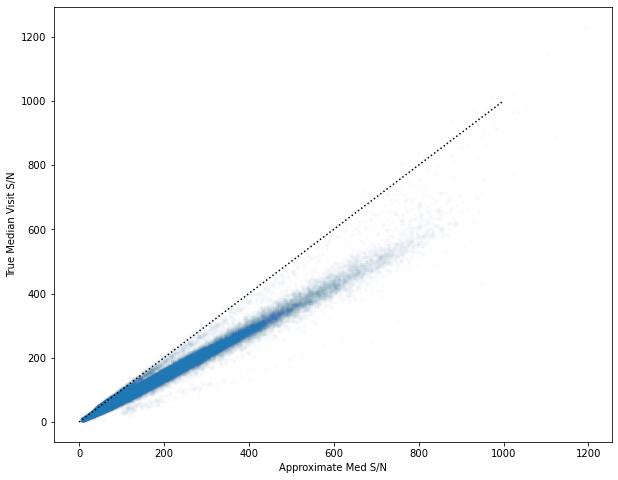

In [10]:
plt.figure(figsize=(10,8))
plt.plot(allStarSmall_tab['VISIT_MED_SNR_APPROX'],allStarSmall_tab['VISIT_MED_SNR'],'.',alpha=0.01)
plt.plot(np.linspace(0,1000,10),np.linspace(0,1000,10),'k:')
plt.xlabel('Approximate Med S/N')
plt.ylabel("True Median Visit S/N")
plt.show()

## Limit to only Good Stars
STARFLAG = 0
Think about ASPCAPFLAG = 0

In [11]:
allStarGood_tab = allStarSmall_tab[(allStarSmall_tab['STARFLAG'] == 0)]
allStarGood_tab

APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,TARGFLAGS,NVISITS,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,PARAM [7],FPARAM [7],"PARAM_COV [7,7]","FPARAM_COV [7,7]",ELEM [15],FELEM [15],ELEM_ERR [15],FELEM_ERR [15],TEFF,LOGG,PARAM_M_H,PARAM_ALPHA_M,TEFF_ERR,LOGG_ERR,PARAM_M_H_ERR,PARAM_ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [7],AL_H,CA_H,C_H,FE_H,K_H,MG_H,MN_H,NA_H,NI_H,N_H,O_H,SI_H,S_H,TI_H,V_H,AL_H_ERR,CA_H_ERR,C_H_ERR,FE_H_ERR,K_H_ERR,MG_H_ERR,MN_H_ERR,NA_H_ERR,NI_H_ERR,N_H_ERR,O_H_ERR,SI_H_ERR,S_H_ERR,TI_H_ERR,V_H_ERR,AL_H_FLAG,CA_H_FLAG,C_H_FLAG,FE_H_FLAG,K_H_FLAG,MG_H_FLAG,MN_H_FLAG,NA_H_FLAG,NI_H_FLAG,N_H_FLAG,O_H_FLAG,SI_H_FLAG,S_H_FLAG,TI_H_FLAG,V_H_FLAG,ELEM_CHI2 [15],ELEMFLAG [15],REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,ALL_VISITS,VISITS,ALL_VISIT_PK [50],VISIT_PK [50],VISIT_MED_SNR,VISIT_MED_SNR_APPROX
bytes45,bytes34,bytes44,bytes34,bytes18,bytes8,int16,bytes16,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,bytes116,int32,int16,float32,int32,bytes129,int32,bytes59,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes5,bytes6,bytes4,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes2,int32,bytes153,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32,bytes18,bytes12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes17,float32,float32,int16,int16,float32,float32,bytes20,bytes737,bytes665,int32,int32,float32,float64
apogee.apo25m.s.stars.4264.2M00000032+5737103,4264.2M00000032+5737103,apogee.apo25m.s.v603.4264.2M00000032+5737103,apStar-r5-2M00000032+5737103.fits,2M00000032+5737103,apo25m,4264,N7789,10.905,0.023,10.635,0.03,10.483,0.022,0.001335,57.61953,116.065370948,-4.56476751408,-2147481600,0,APOGEE_SHORT,3,0,229.6,0,,0,,-20.136,0.0142051,0.044076,0.0776521,-20.2174,0.162068,0.0350446,0.0621817,6250.0,4.0,-0.5,30.811,22.4187,0.147979,0.06756286 .. 13.861421,0.18379726 .. 2.6326241,13.815598 .. 13.815598,0.9667828 .. 0.0009772778,stars,l25_6d,v603,16,-9999.0 .. -9999.0,6482.9 .. 0.033873,-9999.0 .. -9999.0,221.3 .. 2.279e-05,-9999.0 .. -9999.0,-0.99705 .. -0.22444,-9999.0 .. -9999.0,0.30364618 .. 0.013669674,-9999.0,-9999.0,-9999.0,-9999.0,-1.0,-1.0,-1.0,-1.0,3.1447055,F,0,,514 .. 2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2,2,258,2,2,2,2,259,2,258,2,2,2,2,2,2.5772111 .. 2.3628166,258 .. 2,2M00000032+5737103,2MASS,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,10.447,0.02,10.43,0.0,0.10556992,RJCE_WISE_PARTSKY,0.12668462,-9999.99,-1,1,0.0,0.0,NOM

## Initial Plots

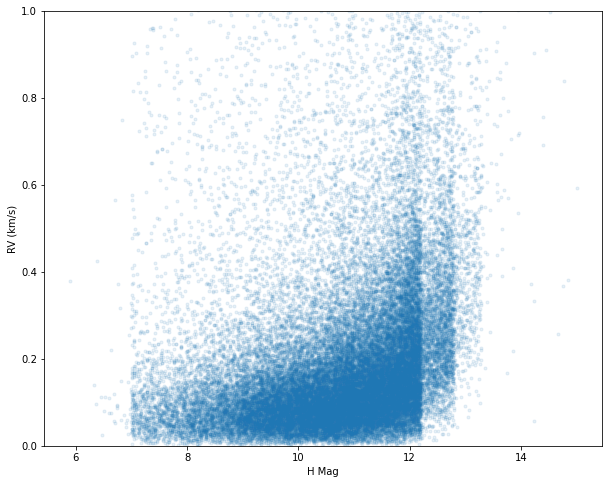

In [12]:
plt.figure(figsize=(10,8))
plt.plot(allStarGood_tab['H'],allStarGood_tab['VSCATTER'],'.',alpha=0.1)
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
plt.ylim(0,1)
plt.show()

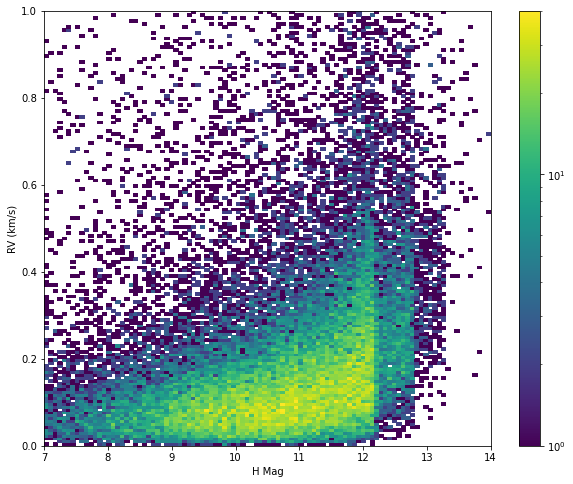

In [13]:
plt.figure(figsize=(10,8))
plt.hist2d(allStarGood_tab['H'],allStarGood_tab['VSCATTER'],bins=(100,150),range=((7,14),(0,1.0)),
           norm=mpl.colors.LogNorm())
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
#plt.yscale('log')
#plt.cscale('log')
plt.colorbar()
plt.show()

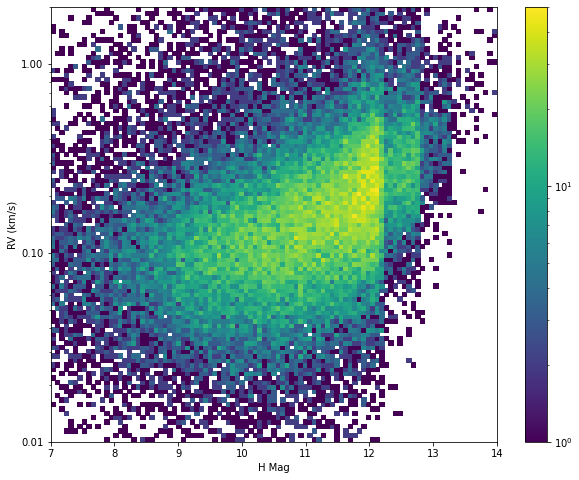

In [14]:
plt.figure(figsize=(10,8))
xbins = np.linspace(7, 14, 100)
ybins = 10**np.linspace(-2, .3, 100)
counts, _, _ = np.histogram2d(allStarGood_tab['H'],allStarGood_tab['VSCATTER'],bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
plt.yscale('log')
plt.colorbar()
plt.ylim(0.01,2)
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.show()

Zeropoint: 10.58 +/- 0.011


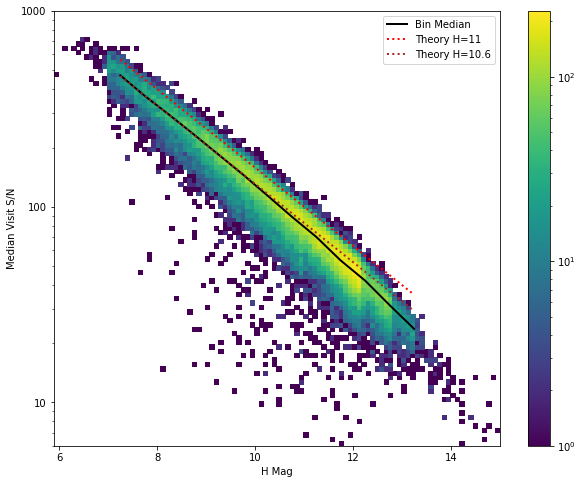

In [15]:
plt.figure(figsize=(10,8))
ybins = 10**np.linspace(np.log10(6), 3, 100)
plt.hist2d(allStarGood_tab['H'],allStarGood_tab['VISIT_MED_SNR'],bins=(100,ybins), \
           norm=mpl.colors.LogNorm())
xbins2 = np.linspace(7,13.5,14)
(median_arr,xbins2_arr,indice_arr) = stats.binned_statistic(allStarGood_tab['H'],\
                                                            allStarGood_tab['VISIT_MED_SNR'], statistic='median', \
                                                            bins=xbins2)
xbinCen_arr = (xbins2_arr[0:-1] + xbins2_arr[1:])/2
(param,cov) = curve_fit(fit_h2sn,xbinCen_arr,median_arr,p0=[11])
perr = np.sqrt(np.diag(cov))
print("Zeropoint: {:.2f} +/- {:.3f}".format(param[0],perr[0]))

plt.plot(xbinCen_arr,median_arr,lw=2,c='k', label="Bin Median")
plt.plot(xbinCen_arr,h2sn(xbinCen_arr,exptime=60),'r:',lw=2,label="Theory H=11")
plt.plot(xbinCen_arr,h2sn(xbinCen_arr,exptime=60,zeropoint=param[0]),':', c='brown',lw=2, \
         label="Theory H={:.1f}".format(param[0]))
plt.xlabel("H Mag")
plt.ylabel("Median Visit S/N")
plt.yscale('log')
plt.colorbar()
plt.legend()
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.savefig('DR17_Hvsn.png',dpi=200)
plt.show()

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]


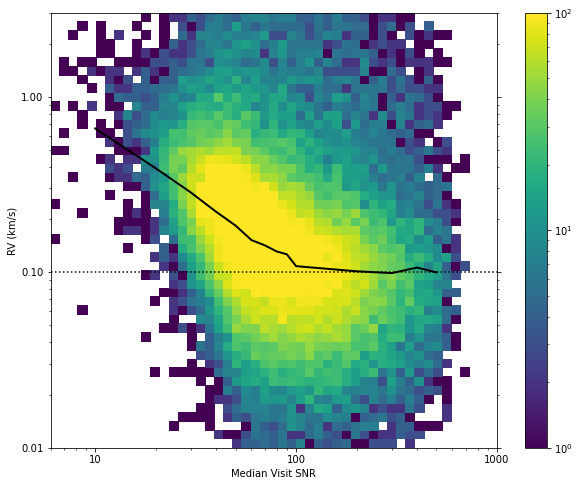

In [16]:
plt.figure(figsize=(10,8))
xbins = 10**np.linspace(np.log10(6), 3, 50)
#xbins2 = xbins[11:-2]
xbins2 = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600]
ybins = 10**np.linspace(-2,np.log10(3), 50)

(median_arr,xbins2_arr,indice_arr) = stats.binned_statistic(allStarGood_tab['VISIT_MED_SNR'],allStarGood_tab['VSCATTER'], statistic='median', \
                       bins=xbins2)
#xbinCen_arr = (xbins2_arr[0:-1] + xbins2_arr[1:])/2
xbinCen_arr = xbins2[0:-1]
print(xbinCen_arr)

counts, _, _ = np.histogram2d(allStarGood_tab['VISIT_MED_SNR'],allStarGood_tab['VSCATTER'],bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.plot(xbinCen_arr,median_arr,lw=2,c='k')
plt.xlabel("Median Visit SNR")
plt.ylabel("RV (km/s)")
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.ylim(0.01,3)
plt.clim(1,100)
plt.gca().axhline(0.10,c="k",ls=":")
plt.tick_params(axis='y', which='both', left=True, right=True,labelleft=True, labelright=False)
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.show()

[  301.  1702.  3853.  5158.  5057.  4155.  3392.  2828.  2393. 11752.
  3381.  1400.   631.   249.]


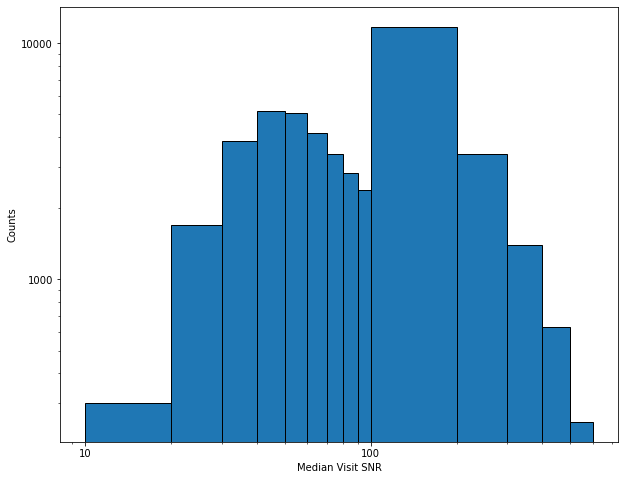

In [17]:
plt.figure(figsize=(10,8))
(counts,bins,_) = plt.hist(allStarGood_tab['VISIT_MED_SNR'],xbins2,edgecolor='k')
plt.xlabel("Median Visit SNR")
plt.ylabel("Counts")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
print(counts)

In [18]:
dr12_tab = Table()
dr12_tab['Visit_SNR'] = xbinCen_arr
dr12_tab['RV_all'] = median_arr
dr12_tab.write('dr12fit_all.fits',overwrite=True)
dr12_tab

Visit_SNR,RV_all
int64,float64
10,0.6592569947242737
20,0.3912475109100342
30,0.2842490077018738
40,0.22104600071907043
50,0.18438099324703217
60,0.15240900218486786
70,0.14222650229930878
80,0.1314224898815155
90,0.12651099264621735


## Reproduce David's plot
1. Dwarfs: log >= 4.1
2. Subgiants: 3.5 <= log g < 4.1 (or Teff >= 5000K and 3.0 <= log g <3.5)
3. Giants: log g <= 3.0 (or Teff < 5000 K and 3.0 <= log g < 3.5).

In [19]:
david_tab = allStarSmall_tab[(allStarSmall_tab['LOGG'] < 3.0) & (allStarSmall_tab['SNR']>= 20) & (allStarSmall_tab['NVISITS'] >= 3)]
david_tab

APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,TARGFLAGS,NVISITS,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,PARAM [7],FPARAM [7],"PARAM_COV [7,7]","FPARAM_COV [7,7]",ELEM [15],FELEM [15],ELEM_ERR [15],FELEM_ERR [15],TEFF,LOGG,PARAM_M_H,PARAM_ALPHA_M,TEFF_ERR,LOGG_ERR,PARAM_M_H_ERR,PARAM_ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [7],AL_H,CA_H,C_H,FE_H,K_H,MG_H,MN_H,NA_H,NI_H,N_H,O_H,SI_H,S_H,TI_H,V_H,AL_H_ERR,CA_H_ERR,C_H_ERR,FE_H_ERR,K_H_ERR,MG_H_ERR,MN_H_ERR,NA_H_ERR,NI_H_ERR,N_H_ERR,O_H_ERR,SI_H_ERR,S_H_ERR,TI_H_ERR,V_H_ERR,AL_H_FLAG,CA_H_FLAG,C_H_FLAG,FE_H_FLAG,K_H_FLAG,MG_H_FLAG,MN_H_FLAG,NA_H_FLAG,NI_H_FLAG,N_H_FLAG,O_H_FLAG,SI_H_FLAG,S_H_FLAG,TI_H_FLAG,V_H_FLAG,ELEM_CHI2 [15],ELEMFLAG [15],REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,ALL_VISITS,VISITS,ALL_VISIT_PK [50],VISIT_PK [50],VISIT_MED_SNR,VISIT_MED_SNR_APPROX
bytes45,bytes34,bytes44,bytes34,bytes18,bytes8,int16,bytes16,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,bytes116,int32,int16,float32,int32,bytes129,int32,bytes59,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes5,bytes6,bytes4,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes2,int32,bytes153,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32,bytes18,bytes12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes17,float32,float32,int16,int16,float32,float32,bytes20,bytes737,bytes665,int32,int32,float32,float64
apogee.apo25m.s.stars.4424.2M00000032+5737103,4424.2M00000032+5737103,apogee.apo25m.s.v603.4424.2M00000032+5737103,apStar-r5-2M00000032+5737103.fits,2M00000032+5737103,apo25m,4424,116-04,10.905,0.023,10.635,0.03,10.483,0.022,0.0013349975,57.61953,116.065370947,-4.56476751381,-2147483584,-2147483104,"APOGEE_NO_DERED,APOGEE_SKY_BAD,APOGEE_TELLURIC",3,0,235.435,512,PERSIST_HIGH,512,PERSIST_HIGH,-20.8405,0.161311,0.0398491,0.0680206,-20.6008,0.0793453,0.0305275,0.051365,6000.0,4.0,-0.5,30.378,22.9432,0.160516,9.25768 .. 5.496159,2.151474 .. 1.6577332,13.815598 .. 13.815598,0.009766102 .. 0.064050734,stars,l25_6d,v603,4,-9999.0 .. -9999.0,6295.2 .. 0.019301,-9999.0 .. -9999.0,197.84 .. 2.2606e-05,-9999.0 .. -9999.0,0.63859 .. -0.29016,-9999.0 .. -9999.0,0.024368422 .. 0.01347813,-9999.0,-9999.0,-9999.0,-9999.0,-1.0,-1.0,-1.0,-1.0,4.547262,F,64,N_M_WARN,514 .. 2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2,2,2,2,2,2,2,2,2,258,2,2,2,2,259,8.247076 .. 3.208337,2 .. 2,2M00000032+5737103,2MASS,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,10.447,0

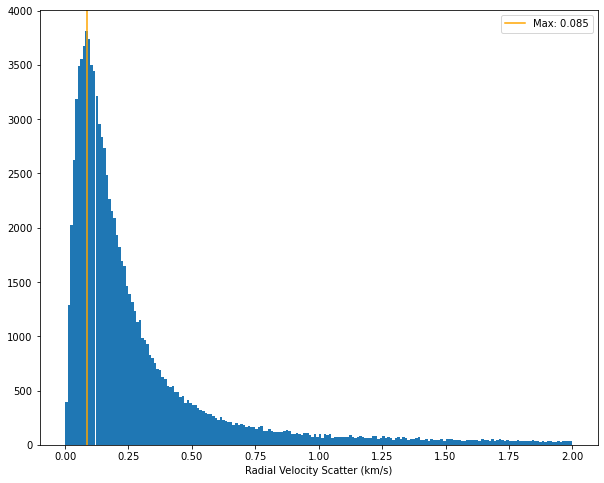

In [20]:
plt.figure(figsize=(10,8))
(counts,bins,patches) = plt.hist(david_tab['VSCATTER'],200,(0,2))
max_ind = np.argmax(counts)
max_cen = (bins[max_ind] + bins[max_ind+1]) /2
plt.gca().axvline(max_cen,c='orange',label='Max: {:0.3f}'.format(max_cen))
#plt.gca().axvline(0.1,c='k',label='0.1 km/s')
plt.xlabel("Radial Velocity Scatter (km/s)")
plt.legend()
plt.show()

In [21]:
david2_tab = allStarSmall_tab[(allStarSmall_tab['TEFF'] > 4000) & (allStarSmall_tab['TEFF'] < 4500)]
david2_tab

APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,TARGFLAGS,NVISITS,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,PARAM [7],FPARAM [7],"PARAM_COV [7,7]","FPARAM_COV [7,7]",ELEM [15],FELEM [15],ELEM_ERR [15],FELEM_ERR [15],TEFF,LOGG,PARAM_M_H,PARAM_ALPHA_M,TEFF_ERR,LOGG_ERR,PARAM_M_H_ERR,PARAM_ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [7],AL_H,CA_H,C_H,FE_H,K_H,MG_H,MN_H,NA_H,NI_H,N_H,O_H,SI_H,S_H,TI_H,V_H,AL_H_ERR,CA_H_ERR,C_H_ERR,FE_H_ERR,K_H_ERR,MG_H_ERR,MN_H_ERR,NA_H_ERR,NI_H_ERR,N_H_ERR,O_H_ERR,SI_H_ERR,S_H_ERR,TI_H_ERR,V_H_ERR,AL_H_FLAG,CA_H_FLAG,C_H_FLAG,FE_H_FLAG,K_H_FLAG,MG_H_FLAG,MN_H_FLAG,NA_H_FLAG,NI_H_FLAG,N_H_FLAG,O_H_FLAG,SI_H_FLAG,S_H_FLAG,TI_H_FLAG,V_H_FLAG,ELEM_CHI2 [15],ELEMFLAG [15],REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,ALL_VISITS,VISITS,ALL_VISIT_PK [50],VISIT_PK [50],VISIT_MED_SNR,VISIT_MED_SNR_APPROX
bytes45,bytes34,bytes44,bytes34,bytes18,bytes8,int16,bytes16,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,bytes116,int32,int16,float32,int32,bytes129,int32,bytes59,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes5,bytes6,bytes4,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes2,int32,bytes153,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32,bytes18,bytes12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes17,float32,float32,int16,int16,float32,float32,bytes20,bytes737,bytes665,int32,int32,float32,float64
apogee.apo25m.s.stars.4264.2M00001653+5540107,4264.2M00001653+5540107,apogee.apo25m.s.v603.4264.2M00001653+5540107,apStar-r5-2M00001653+5540107.fits,2M00001653+5540107,apo25m,4264,N7789,11.337,0.024,10.544,0.031,10.354,0.023,0.068896,55.66964,115.713118876,-6.48324025734,-2147481600,0,APOGEE_SHORT,4,0,250.075,0,,0,,-106.272,0.0986605,0.00628282,0.0129964,-106.262,0.0553558,0.00556366,0.0116375,4000.0,1.0,-0.5,20.8164,20.3364,0.0497528,195.35828 .. 72.38417,8.06966 .. 4.912032,16.266323 .. 16.266323,0.0 .. 0.0,stars,l25_6d,v603,0,4159.0977 .. 0.17733136,4069.6 .. 0.18936,8366.164 .. 0.00015879307,0.82107 .. 7.0344e-06,0.078207 .. -0.16221792,0.078207 .. -0.10876,0.026529144 .. 0.03565614,0.0014441953 .. 0.008720378,4159.0977,1.5175145,-0.14919177,0.17733136,91.466736,0.10689308,0.028553339,0.012601312,10.772091,GK,0,,0 .. 0,0.12730233,-0.10691799,-0.048883006,-0.14151315,-0.13764693,0.02010858,-0.12170752,-0.14197992,-0.16221792,0.07495999,0.076596424,0.08913833,0.111968145,0.08461498,-0.21361867,0.048870847,0.025567986,0.026529144,0.03235525,0.047244336,0.021436475,0.02878106,0.08227784,0.03565614,0.05888624,0.019208629,0.03363844,0.030962842,0.03229589,0.094191834,0,0,512,0,0,0,0,0,0,512,0,0,0,0,0,7.5822835 .. 4.251381,512 .. 0,2M00001653+5540107,2MASS,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9

15066
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]
[  95.  508.  922. 1156. 1155. 1121. 1005.  849.  794. 4704. 1609.  710.
  313.  118.]


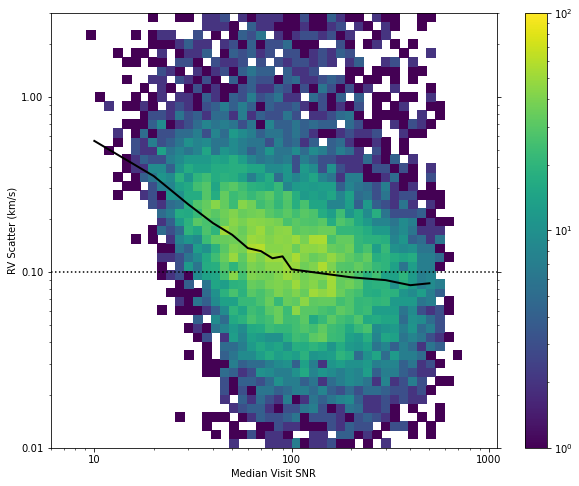

In [22]:
safe_snr_arr = david2_tab['VISIT_MED_SNR'][np.isfinite(david2_tab['VISIT_MED_SNR']) 
                                          & np.isfinite(david2_tab['VSCATTER'])] 
safe_rms_arr = david2_tab['VSCATTER'][np.isfinite(david2_tab['VISIT_MED_SNR']) 
                                          & np.isfinite(david2_tab['VSCATTER'])]
print(len(safe_snr_arr))

plt.figure(figsize=(10,8))
xbins = 10**np.linspace(np.log10(6), 3, 50)
#xbins2 = xbins[11:-2]
xbins2 = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600]
ybins = 10**np.linspace(-2,np.log10(3), 50)
xp = np.linspace(10,200)

(median_arr,xbins2_arr,indice_arr) = stats.binned_statistic(safe_snr_arr,safe_rms_arr, statistic='median', \
                       bins=xbins2)
(count_arr,_,_) = stats.binned_statistic(safe_snr_arr,safe_rms_arr, statistic='count', \
                       bins=xbins2)
#xbinCen_arr = (xbins2_arr[0:-1] + xbins2_arr[1:])/2
xbinCen_arr = xbins2[0:-1]
print(xbinCen_arr)
print(count_arr)

counts, _, _ = np.histogram2d(safe_snr_arr,safe_rms_arr,bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.plot(xbinCen_arr,median_arr,lw=2,c='k')

plt.xlabel("Median Visit SNR")
plt.ylabel("RV Scatter (km/s)")
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.xlim(6,1100)
plt.ylim(0.01,3)
plt.clim(1,100)
plt.gca().axhline(0.10,c="k",ls=":")
plt.tick_params(axis='y', which='both', left=True, right=True,labelleft=True, labelright=False)
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.savefig('DR12_3visit_RVs.png',dpi=200)
plt.show()

[  95.  508.  922. 1156. 1155. 1121. 1005.  849.  794. 4704. 1609.  710.
  313.  118.]


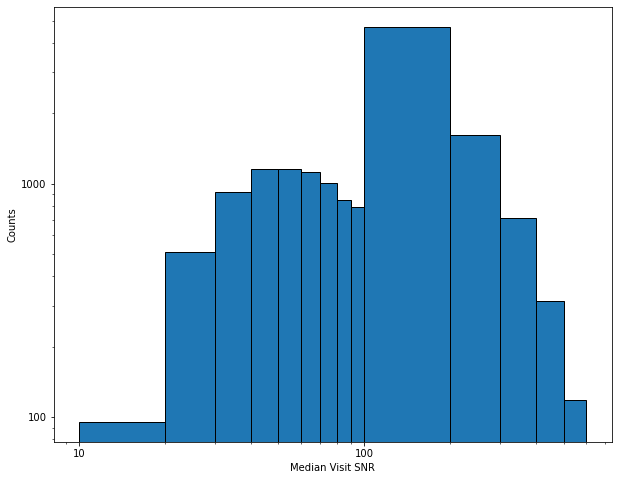

In [23]:
plt.figure(figsize=(10,8))
(counts,bins,_) = plt.hist(safe_snr_arr,xbins2,edgecolor='k')
plt.xlabel("Median Visit SNR")
plt.ylabel("Counts")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
print(counts)

## Save Analysis Results

In [24]:
dr12_tab = Table()
dr12_tab['Visit_SNR'] = xbinCen_arr
dr12_tab['RV_david'] = median_arr
dr12_tab.write('dr12fit_david.fits',overwrite=True)
dr12_tab

Visit_SNR,RV_david
int64,float64
10,0.5598750114440918
20,0.3530769944190979
30,0.24320900440216064
40,0.19032199680805206
50,0.1634110063314438
60,0.13721400499343872
70,0.13182300329208374
80,0.12010099738836288
90,0.1231594979763031
